<h1> Speed Classification </h1>

In [535]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, RocCurveDisplay, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


In [527]:
path ="../IDMT-Traffic/datasets/df_main_encoded_only.csv"
df = pd.read_csv(path)
df.drop(columns=["Unnamed: 0", "file", "is_background_encoded", "location_encoded", "weather_encoded", "channel_encoded"], inplace=True)
#df = df[df["speed_kmh_encoded"] != 1]
#df['speed_kmh_encoded'] = df['speed_kmh_encoded'].replace({2: 1, 3: 2})

print(df.columns)

Index(['date_time_encoded', 'speed_kmh_encoded', 'daytime_encoded',
       'vehicle_encoded', 'source_direction_encoded', 'microphone_encoded',
       'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7',
       'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13',
       'band_1_dB', 'band_2_dB', 'band_3_dB', 'band_4_dB', 'band_5_dB',
       'band_6_dB', 'band_7_dB', 'band_8_dB', 'band_9_dB', 'band_10_dB',
       'band_11_dB', 'band_12_dB', 'band_13_dB', 'band_14_dB', 'band_15_dB',
       'band_16_dB', 'band_17_dB', 'band_18_dB', 'band_19_dB', 'band_20_dB',
       'band_21_dB', 'band_22_dB', 'band_23_dB', 'band_24_dB', 'band_25_dB',
       'band_26_dB', 'band_27_dB', 'band_28_dB', 'band_29_dB', 'peak_dB_1',
       'peak_freq_1', 'peak_dB_2', 'peak_freq_2', 'peak_dB_3', 'peak_freq_3',
       'octband_dB_mean'],
      dtype='object')


   date_time_encoded  speed_kmh_encoded  daytime_encoded  vehicle_encoded  \
0              0.001              0.001            0.001            0.001   

   source_direction_encoded  microphone_encoded  mfcc_1  mfcc_2  mfcc_3  \
0                     0.001               0.001   0.001   0.001   0.001   

   mfcc_4  ...  band_27_dB  band_28_dB  band_29_dB  peak_dB_1  peak_freq_1  \
0   0.001  ...       0.001       0.001       0.001      0.001        0.001   

   peak_dB_2  peak_freq_2  peak_dB_3  peak_freq_3  octband_dB_mean  
0      0.001        0.001      0.001        0.001            0.001  

[1 rows x 55 columns]


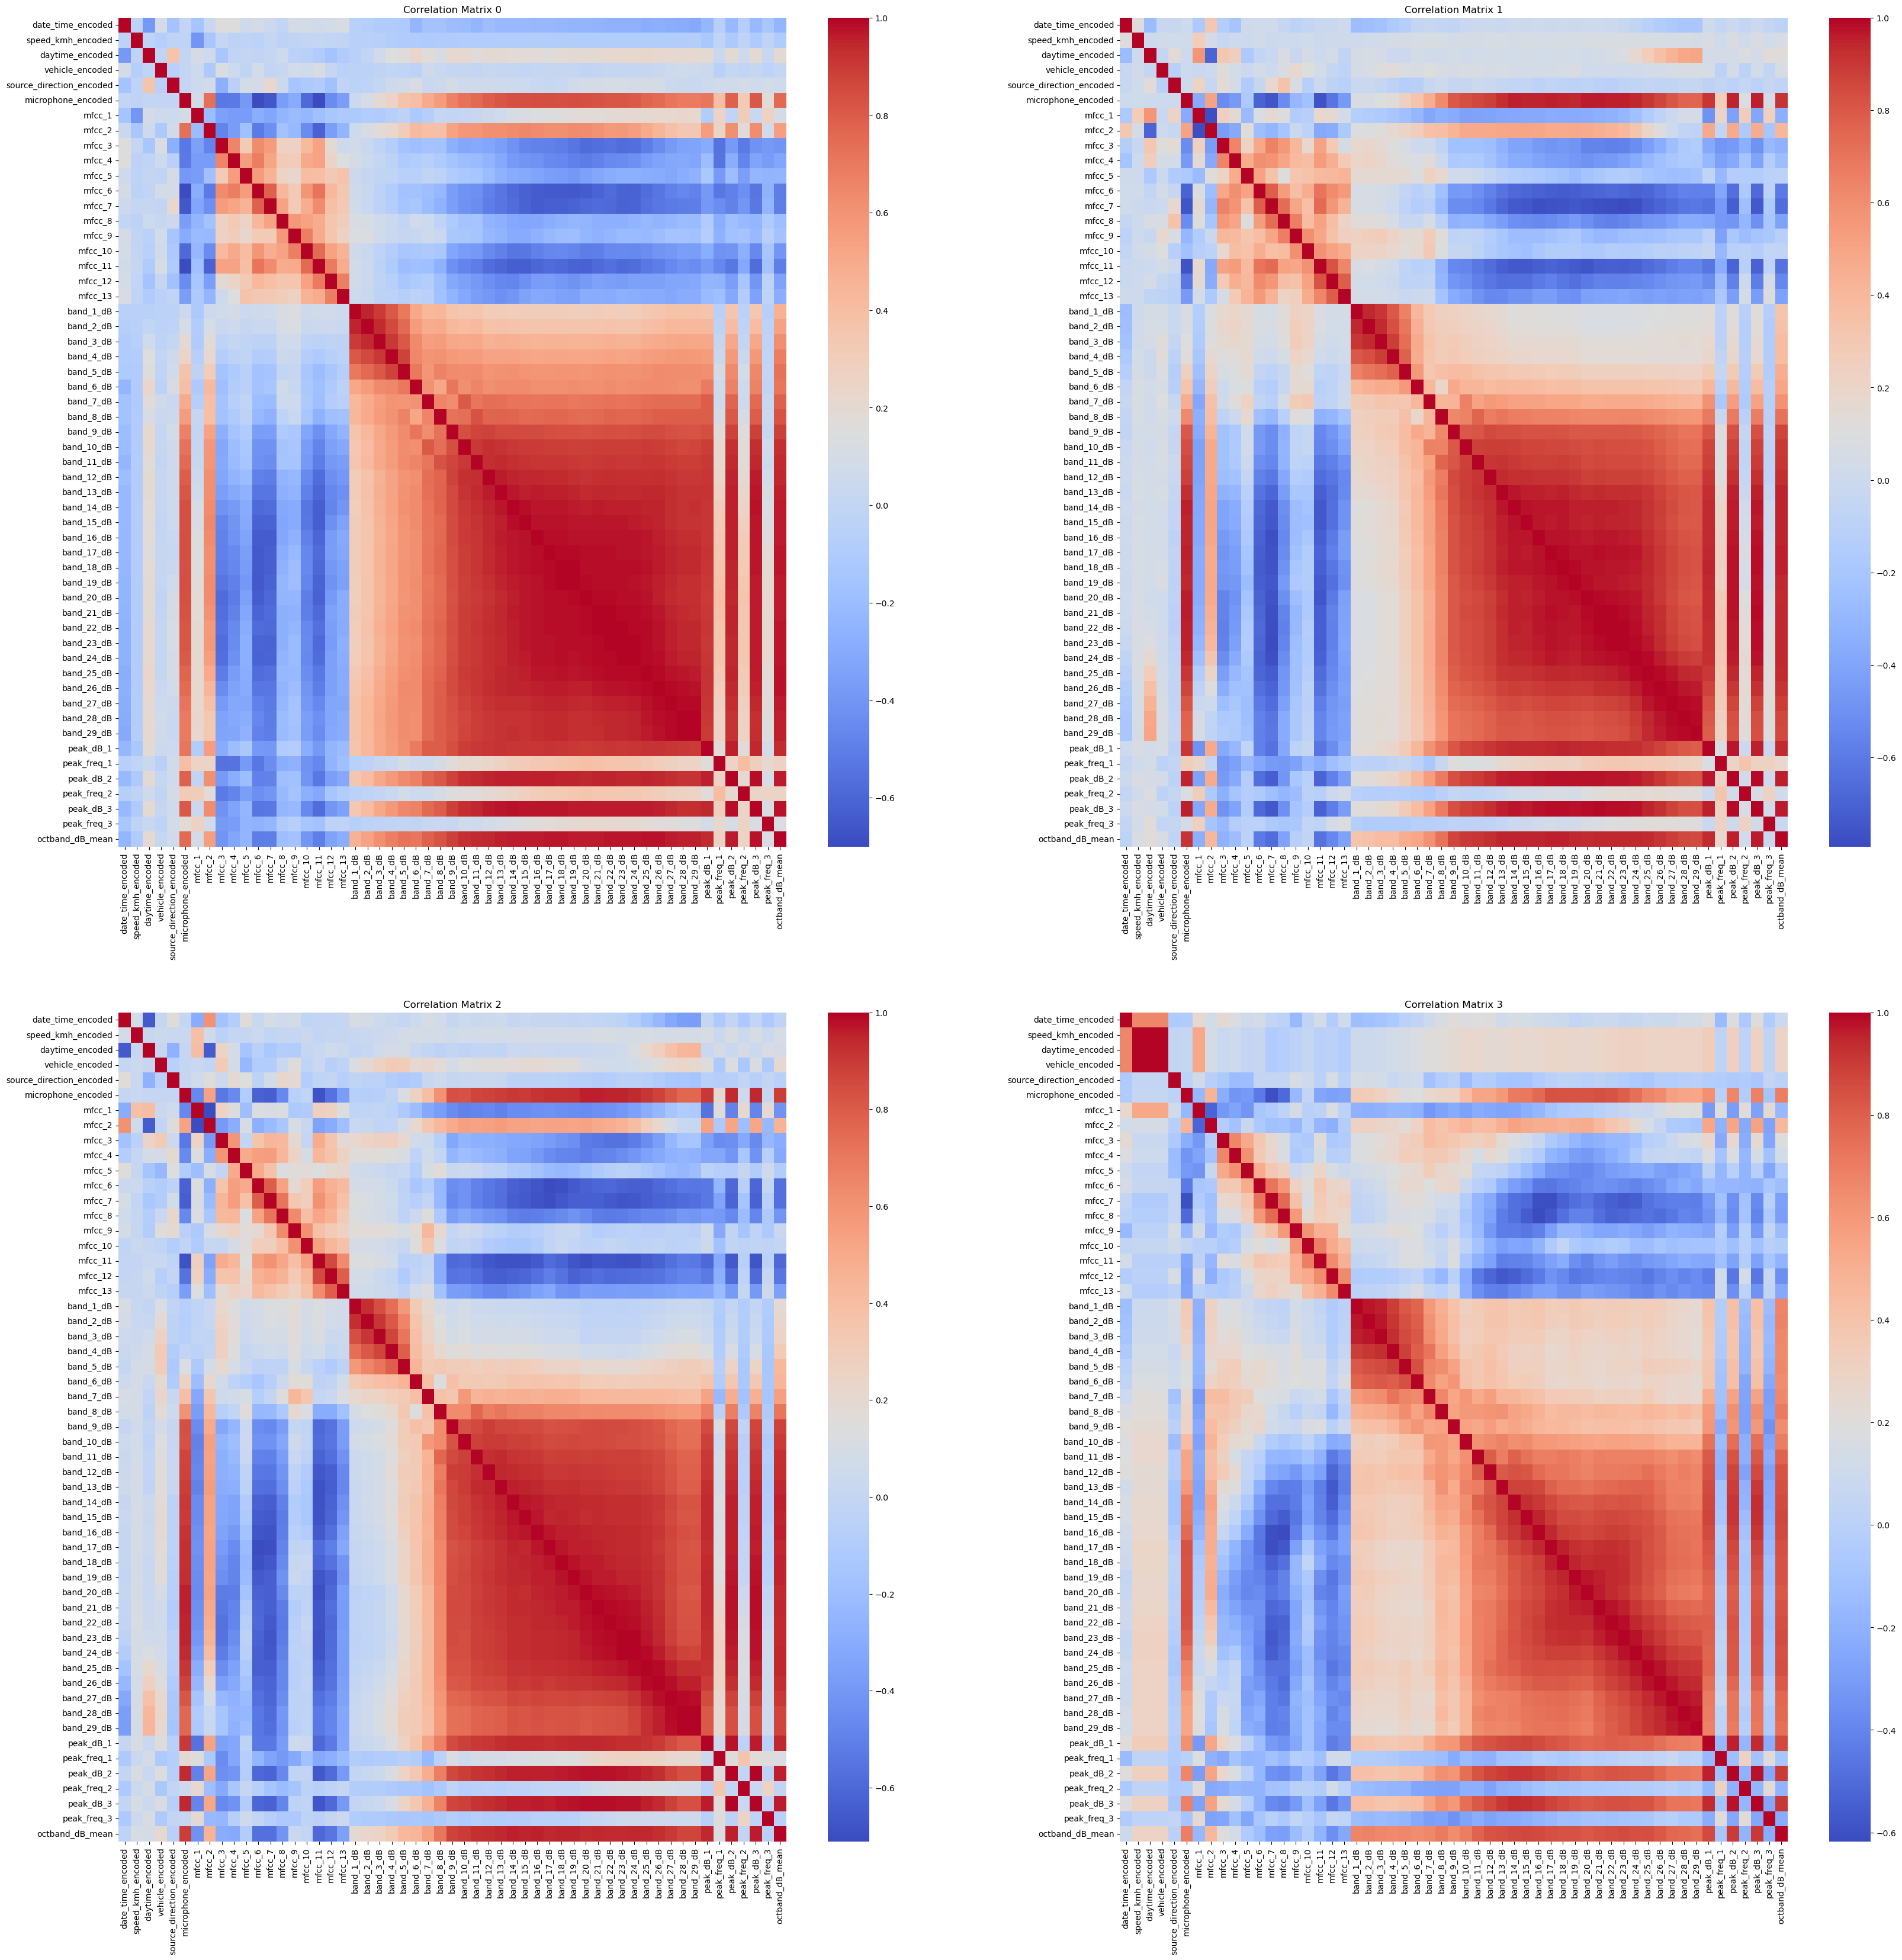

In [528]:
subset_30 = df[df["speed_kmh_encoded"] == 0]
subset_50 = df[df["speed_kmh_encoded"] == 1]
subset_70 = df[df["speed_kmh_encoded"] == 2]
subset_unk = df[df["speed_kmh_encoded"] == 3]

# Adding a row with 0.001 in all columns
new_row = pd.DataFrame([0.001] * subset_30.shape[1], index=subset_30.columns)
new_row = new_row.transpose() 

subset_30 = pd.concat([new_row, subset_30], ignore_index=True)
print(subset_30.head(1))
subset_50 = pd.concat([subset_50, new_row], ignore_index=True)
subset_70 = pd.concat([subset_70, new_row], ignore_index=True)
subset_unk = pd.concat([subset_unk, new_row], ignore_index=True)

subsets = [subset_30, subset_50, subset_70, subset_unk]

fig, axes = plt.subplots(2,2, figsize=(40,40))

for index, subset in enumerate(subsets): 
    correlation_matrix = subset.corr() 
    row = index // 2  
    col = index % 2   
    correlation_matrix = subset.corr()
    sns.heatmap(correlation_matrix, ax=axes[row, col], cmap="coolwarm")
    axes[row, col].set_title(f'Correlation Matrix {index}')


54


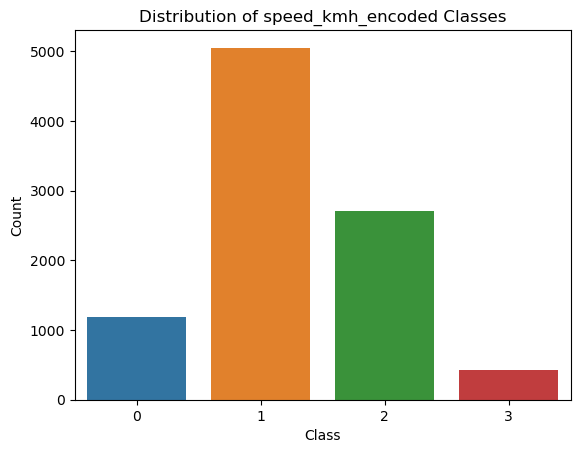

speed_kmh_encoded
1    5054
2    2704
0    1183
3     420
Name: count, dtype: int64


In [529]:

X = df.drop(columns=["speed_kmh_encoded"])
y = df["speed_kmh_encoded"]

print(len(X.columns)) 

sns.countplot(x=y)
plt.title('Distribution of speed_kmh_encoded Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

print(y.value_counts())

In [530]:
# Assuming X and y are already defined
scaler = StandardScaler() 

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<Axes: >

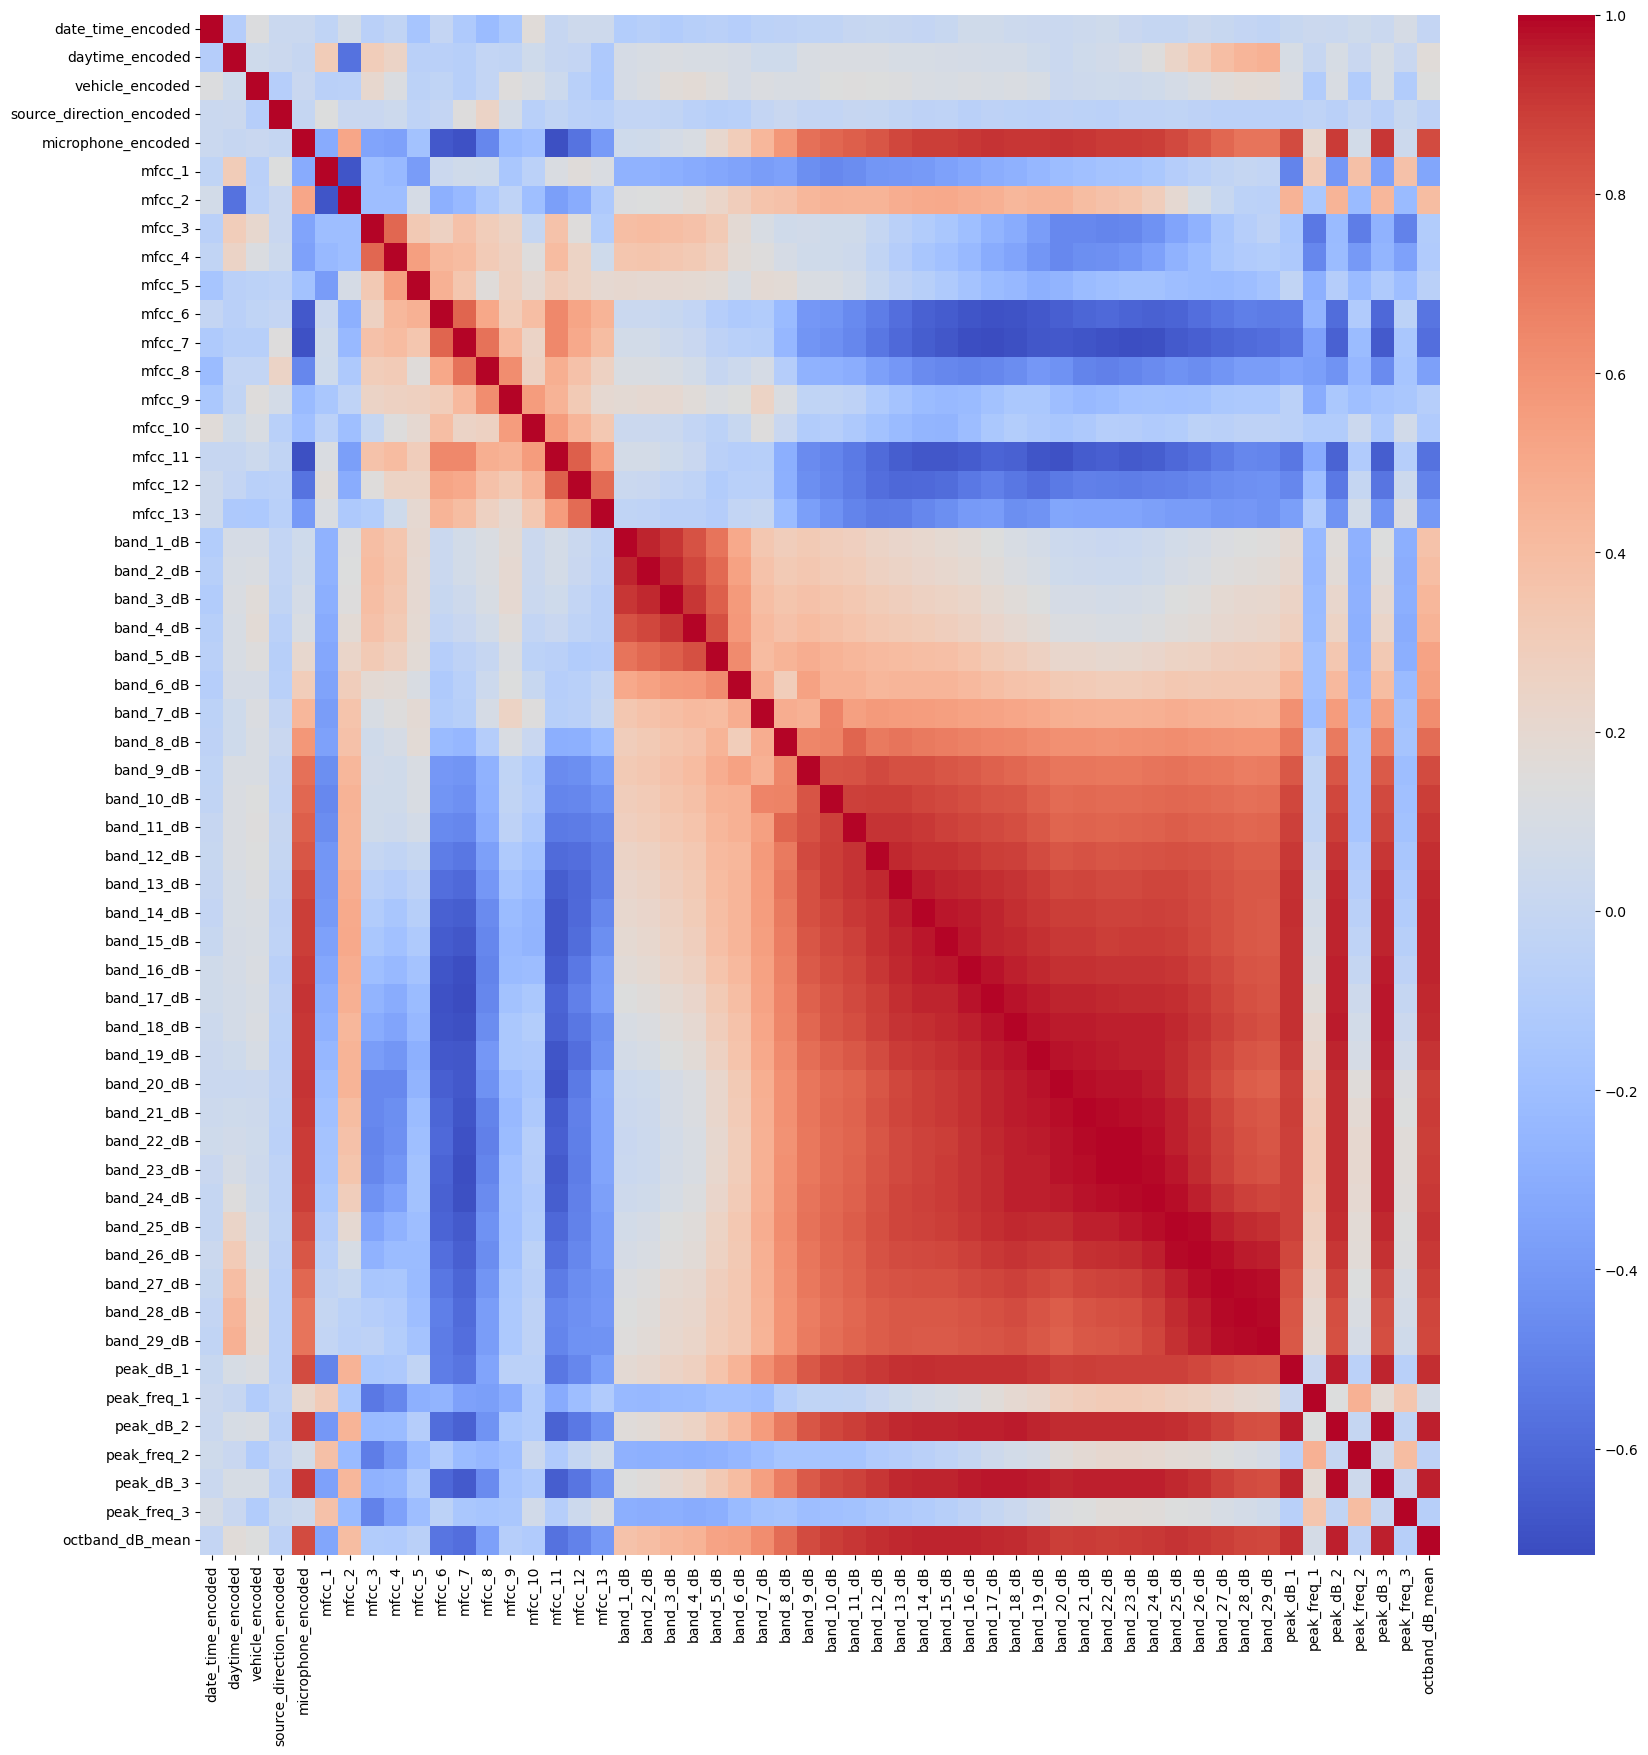

In [532]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")


In [533]:
smote = SMOTE(sampling_strategy="auto", random_state=42, k_neighbors=4) 
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

In [534]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],  # Regularization strength (lower is stronger)
    'solver': ['lbfgs', 'saga'],  # Solvers that support regularization
    'multi_class': ['multinomial'],
    'class_weight': ['balanced']  # Handle class imbalance
}

# Hyperparameter tuning with GridSearchCV
grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=500, random_state=42),
    param_grid_lr,
    scoring='f1_macro',  # Choose a metric that considers class imbalance
    cv=5,
    n_jobs=-1
)

grid_search_lr.fit(X_train_scaled, y_train)

# Best Logistic Regression Model
best_lr = grid_search_lr.best_estimator_
print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)

# Fit and Evaluate
y_pred_lr = best_lr.predict(X_test_scaled)
print(classification_report(y_test, y_pred_lr))



/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters for Logistic Regression: {'C': 10, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00      1034
           2       1.00      1.00      1.00       517
           3       0.95      1.00      0.98        79

    accuracy                           1.00      1873
   macro avg       0.99      1.00      0.99      1873
weighted avg       1.00      1.00      1.00      1873



/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [536]:

param_grid_xgb = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 10],  
    'reg_lambda': [1, 10, 50, 100]  
}

random_search_xgb = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, random_state=42),
    param_distributions=param_grid_xgb,
    n_iter=50, 
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train_scaled, y_train)

# Best XGBoost Model
best_xgb = random_search_xgb.best_estimator_
print("Best Parameters for XGBoost:", random_search_xgb.best_params_)

# Fit and Evaluate
y_pred_xgb = best_xgb.predict(X_test_scaled)
print(classification_report(y_test, y_pred_xgb))



/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/janikwahrheit/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:49:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

Best Parameters for XGBoost: {'subsample': 0.8, 'reg_lambda': 100, 'reg_alpha': 0.1, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00      1034
           2       1.00      1.00      1.00       517
           3       1.00      1.00      1.00        79

    accuracy                           1.00      1873
   macro avg       1.00      1.00      1.00      1873
weighted avg       1.00      1.00      1.00      1873



In [538]:
model3 = RandomForestClassifier(
    n_estimators=500,
    max_depth=10,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42
)

model3.fit(X_train_scaled, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=5, n_estimators=500, random_state=42)

In [524]:
# Define a parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=50,  # Number of iterations to explore
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    random_state=42
)

# Fit RandomizedSearchCV
random_search_rf.fit(X_train_scaled, y_train)

# Best Random Forest Model
best_rf = random_search_rf.best_estimator_
print("Best Parameters for Random Forest:", random_search_rf.best_params_)

# Fit and Evaluate
y_pred_rf = best_rf.predict(X_test_scaled)
print(classification_report(y_test, y_pred_rf))





KeyboardInterrupt: 

In [539]:
# Add noise to the test data
noise_level = 0.05  
X_test_noisy = X_test_scaled.copy()


std_devs = np.std(X_test_scaled, axis=0) 
noise = np.random.normal(0, noise_level * std_devs, X_test_scaled.shape) 
X_test_noisy += noise  

In [521]:
from sklearn.metrics import f1_score

# Compare F1 scores on original and noisy data

y_pred = model3.predict(X_test_scaled)
y_pred_noisy = model3.predict(X_test_noisy)

f1_original = f1_score(y_test, y_pred, average="macro")
f1_noisy = f1_score(y_test, y_pred_noisy, average="macro")

print(f"- F1 Score on Original Data: {f1_original:.4f}")
print(f" - F1 Score on Noisy Data: {f1_noisy:.4f}")
print(f" - F1 Score Drop: {f1_original - f1_noisy:.4f}")
print("-" * 50)


- F1 Score on Original Data: 0.9982
 - F1 Score on Noisy Data: 0.9939
 - F1 Score Drop: 0.0043
--------------------------------------------------


In [541]:
models = {
    "Logistic Regression": best_lr,
    "XGBoost": best_xgb,
    "Random Forest": model3
}

for name, model in models.items():
    print(50*"-")
    print(name)
    print(50*"-")
    print(f"Evaluating {name} on test data...")
    y_pred= model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    print(50*"-")
    print(f"Evaluating {name} on noisy test data...")
    y_pred_noisy = model.predict(X_test_noisy)
    print(classification_report(y_test, y_pred_noisy))


--------------------------------------------------
Logistic Regression
--------------------------------------------------
Evaluating Logistic Regression on test data...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00      1034
           2       1.00      1.00      1.00       517
           3       0.95      1.00      0.98        79

    accuracy                           1.00      1873
   macro avg       0.99      1.00      0.99      1873
weighted avg       1.00      1.00      1.00      1873

--------------------------------------------------
Evaluating Logistic Regression on noisy test data...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00      1034
           2       1.00      1.00      1.00       517
           3       0.96      1.00      0.98        79

    accuracy        

<Axes: >

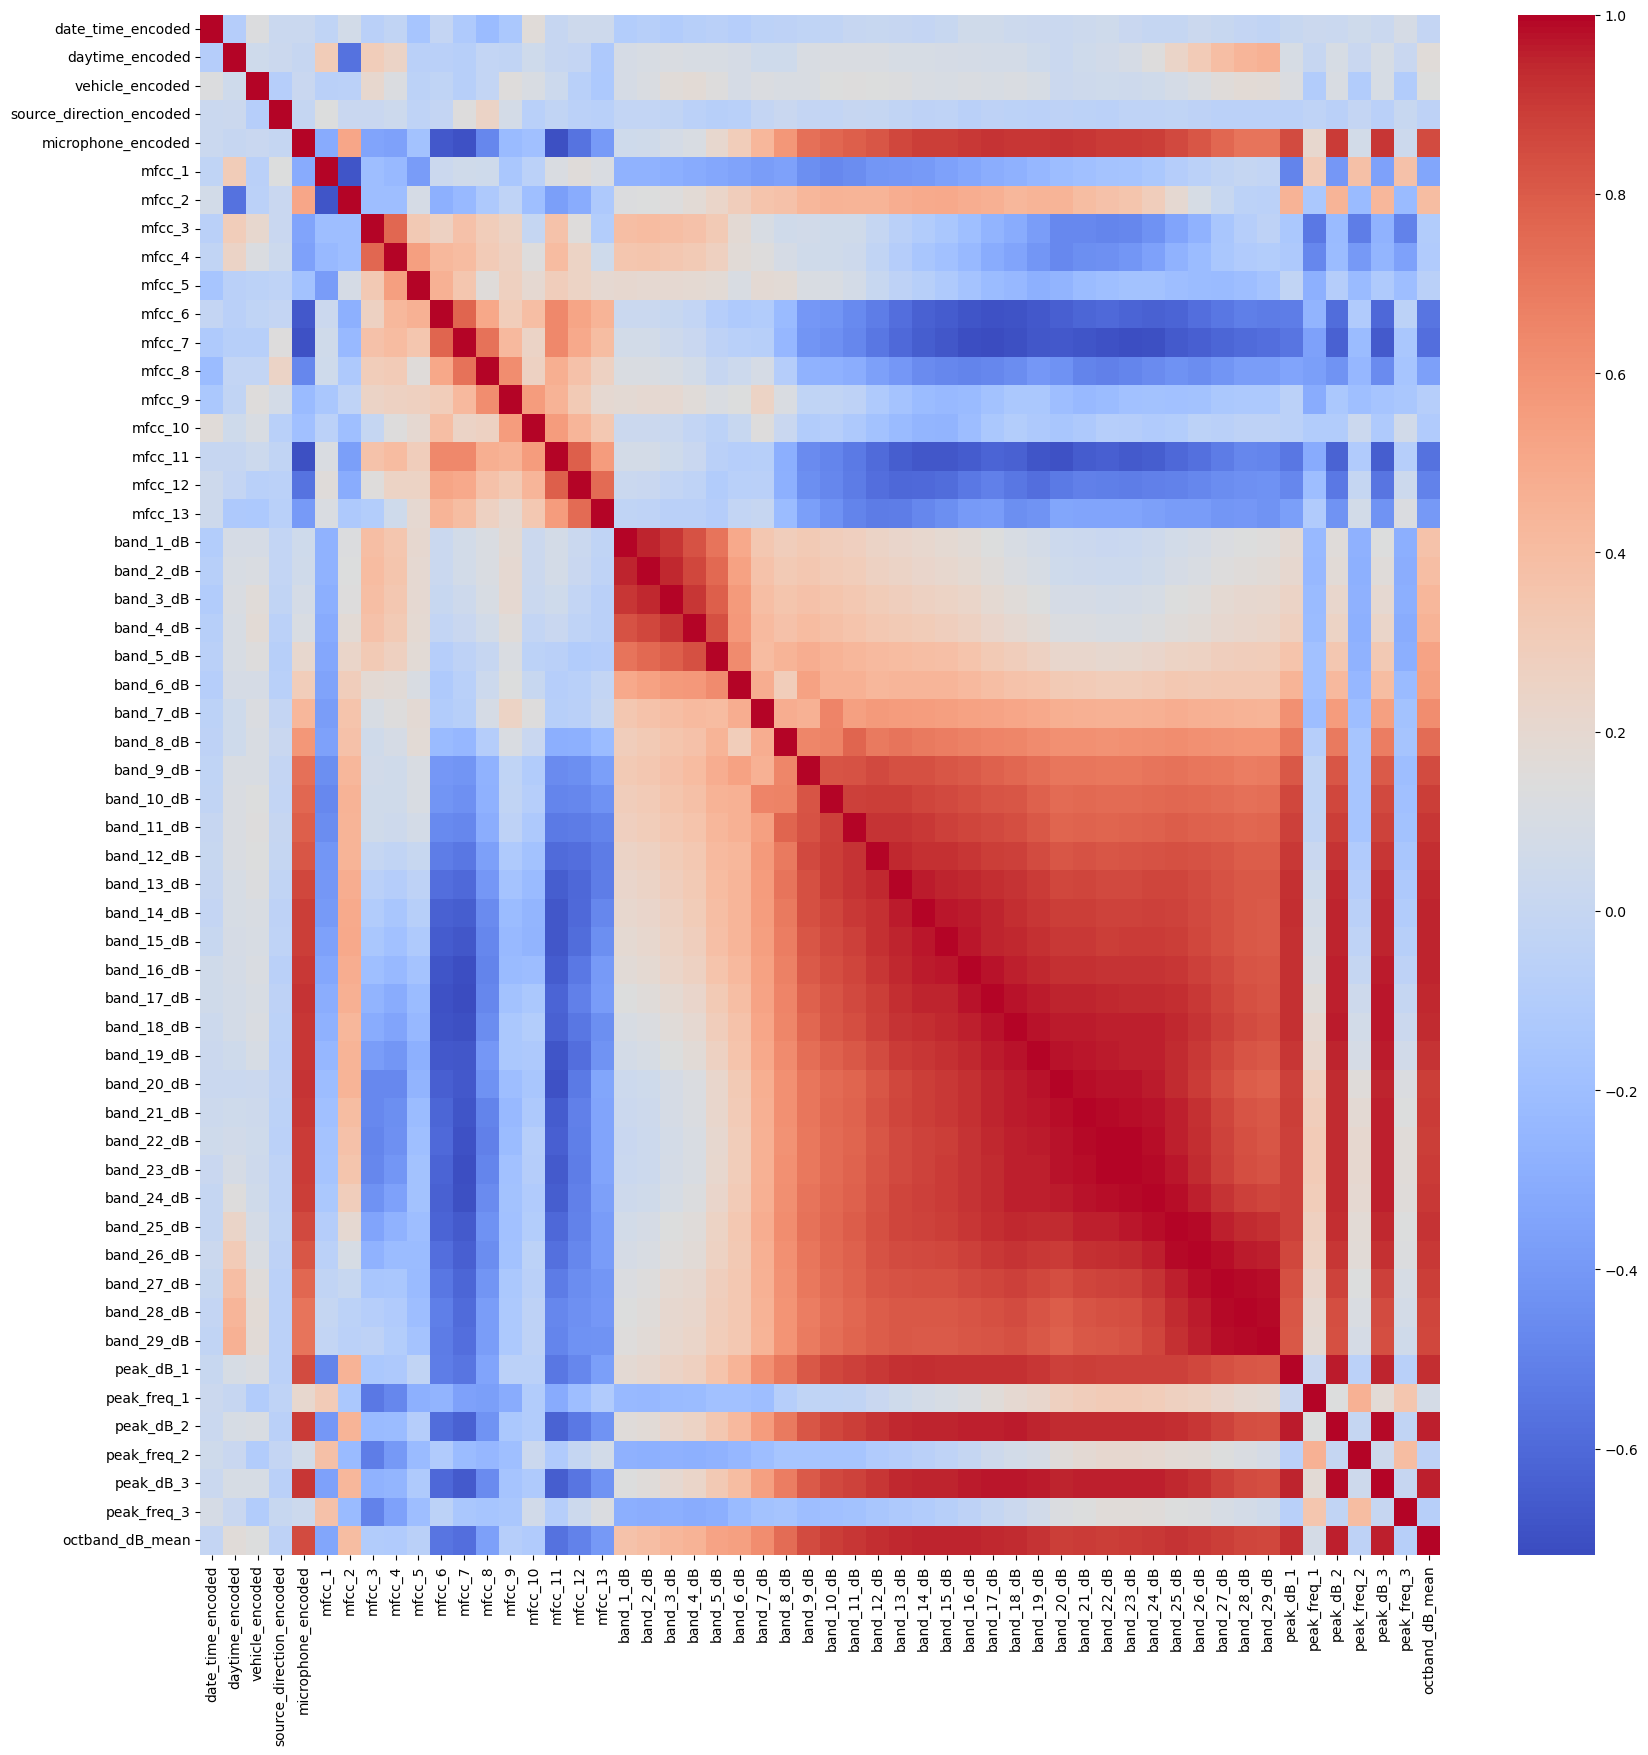

In [ ]:
fig = plt.figure(figsize=(20,20))
sns.heatmap(X_train.corr(), cmap="coolwarm")
